In [22]:
import numpy as np 
import pandas as pd  
import torch
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import torch.nn.functional as F 

data_dir = './data'

In [23]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import resnet50

In [24]:
class CNFG:
    epochs =20                             
    lr = 0.001                             
    batch_size = 256              
    img_size = 224
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cuda


In [25]:
data_transform = T.Compose([
                             T.Resize(size=(CNFG.img_size,CNFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [26]:
data = datasets.ImageFolder(data_dir,       
                    transform=data_transform)
total_count = len(data) 
total_count

158

In [27]:
train_count = int(0.6 * total_count) 
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))  
print("Train data: {} images".format(len(train_data))) 
print("Validation data: {} images".format(len(val_data))) 
print("Test data: {} images".format(len(test_data)))

Train data: 94 images
Validation data: 47 images
Test data: 17 images


In [28]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [29]:
train_data.dataset.classes

['defect_cars', 'non-defect_cars']

In [30]:
train_data

In [31]:
trainloader = DataLoader(train_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))  
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:1
No. of Total examples:94
No. of batches in validationloader:1
No. of Total examples:47
No. of batches in testloader:1
No. of Total examples:17


In [32]:
trainloader

In [33]:
from torch import nn
import torch.nn.functional as F
# import timm # PyTorch Image Models

model = resnet50(pretrained=True) #load pretrained model

In [34]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
#Updating the pretrained model:
for param in model.parameters():
    param.requires_grad=False 

In [36]:
model.fc = nn.Linear(in_features=2048,out_features = 2, bias=True)

In [37]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
from torchsummary import  summary
model.to(device)# move the model to GPU
summary(model,input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

In [39]:
class ModelTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular 

    
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() 
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) 
            
            model.eval()  
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) 
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'fire_alex_25.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CNFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = 25)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.8857390880584717
Epoch : 1 Train Loss : 0.822377 Train Acc : 0.468085
Epoch : 1 Valid Loss : 0.885739 Valid Acc : 0.468085


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.8857390880584717 --> 0.7903537154197693
Epoch : 2 Train Loss : 0.908385 Train Acc : 0.521277
Epoch : 2 Valid Loss : 0.790354 Valid Acc : 0.489362


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.7903537154197693 --> 0.6803649067878723
Epoch : 3 Train Loss : 0.757822 Train Acc : 0.521277
Epoch : 3 Valid Loss : 0.680365 Valid Acc : 0.553191


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.675520 Train Acc : 0.585106
Epoch : 4 Valid Loss : 0.721986 Valid Acc : 0.531915


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.6803649067878723 --> 0.6672715544700623
Epoch : 5 Train Loss : 0.682676 Train Acc : 0.489362
Epoch : 5 Valid Loss : 0.667272 Valid Acc : 0.553191


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.6672715544700623 --> 0.5828185677528381
Epoch : 6 Train Loss : 0.644925 Train Acc : 0.500000
Epoch : 6 Valid Loss : 0.582819 Valid Acc : 0.765957


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.5828185677528381 --> 0.5823696851730347
Epoch : 7 Train Loss : 0.573409 Train Acc : 0.744681
Epoch : 7 Valid Loss : 0.582370 Valid Acc : 0.702128


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.507074 Train Acc : 0.851064
Epoch : 8 Valid Loss : 0.609516 Valid Acc : 0.659574


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.526777 Train Acc : 0.765957
Epoch : 9 Valid Loss : 0.598517 Valid Acc : 0.595745


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.5823696851730347 --> 0.5647876262664795
Epoch : 10 Train Loss : 0.463602 Train Acc : 0.819149
Epoch : 10 Valid Loss : 0.564788 Valid Acc : 0.765957


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.5647876262664795 --> 0.4781014025211334
Epoch : 11 Train Loss : 0.451673 Train Acc : 0.872340
Epoch : 11 Valid Loss : 0.478101 Valid Acc : 0.872340


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.4781014025211334 --> 0.47121044993400574
Epoch : 12 Train Loss : 0.402783 Train Acc : 0.882979
Epoch : 12 Valid Loss : 0.471210 Valid Acc : 0.851064


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.47121044993400574 --> 0.425143837928772
Epoch : 13 Train Loss : 0.398300 Train Acc : 0.893617
Epoch : 13 Valid Loss : 0.425144 Valid Acc : 0.914894


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.385948 Train Acc : 0.861702
Epoch : 14 Valid Loss : 0.457978 Valid Acc : 0.765957


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.425143837928772 --> 0.4044182598590851
Epoch : 15 Train Loss : 0.382766 Train Acc : 0.904255
Epoch : 15 Valid Loss : 0.404418 Valid Acc : 0.829787


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.4044182598590851 --> 0.3799848258495331
Epoch : 16 Train Loss : 0.346594 Train Acc : 0.882979
Epoch : 16 Valid Loss : 0.379985 Valid Acc : 0.872340


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.306204 Train Acc : 0.936170
Epoch : 17 Valid Loss : 0.390604 Valid Acc : 0.851064


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.283654 Train Acc : 0.904255
Epoch : 18 Valid Loss : 0.414030 Valid Acc : 0.872340


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.284238 Train Acc : 0.904255
Epoch : 19 Valid Loss : 0.417975 Valid Acc : 0.808511


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.266472 Train Acc : 0.904255
Epoch : 20 Valid Loss : 0.396630 Valid Acc : 0.872340


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.3799848258495331 --> 0.3557128608226776
Epoch : 21 Train Loss : 0.283265 Train Acc : 0.914894
Epoch : 21 Valid Loss : 0.355713 Valid Acc : 0.914894


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.265410 Train Acc : 0.904255
Epoch : 22 Valid Loss : 0.362371 Valid Acc : 0.893617


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.3557128608226776 --> 0.3486541211605072
Epoch : 23 Train Loss : 0.236456 Train Acc : 0.914894
Epoch : 23 Valid Loss : 0.348654 Valid Acc : 0.851064


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.255917 Train Acc : 0.936170
Epoch : 24 Valid Loss : 0.380968 Valid Acc : 0.808511


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.3486541211605072 --> 0.33621296286582947
Epoch : 25 Train Loss : 0.245592 Train Acc : 0.914894
Epoch : 25 Valid Loss : 0.336213 Valid Acc : 0.872340


In [43]:
torch.save(model.state_dict(),'car_alex_25.pt')

In [44]:
# test predictions
# load torch model 
# model.load_state_dict(torch.load('ocean_19_15.pt'))
model.load_state_dict(torch.load('car_alex_25.pt'))
model.eval()
test_loss = 0.0
test_acc = 0.0
for images,labels in tqdm(testloader):
        
        # move the data to CPU
        images = images.to(device) 
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        test_loss += loss.item()
        test_acc += accuracy(outputs,labels)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(test_loss / len(testloader), test_acc / len(testloader)))

  0%|          | 0/1 [00:00<?, ?it/s]

Test Loss : 0.345871 Test Acc : 0.823529


## Make predictions

In [47]:
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F 
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import alexnet
from torch import nn


data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                            #  T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

]) 

class_map = [ 
    'defect',
    'no_defect'
]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# def predict_image(image_path,model):
#     image = Image.open(image_path)
#     image = data_transform(image)
#     image = image.unsqueeze(0)
#     image = image.to(device)
#     model.eval()
#     output = model(image)
#     output = F.softmax(output,dim = 1)
#     top_p,top_class = output.topk(1,dim = 1)
#     return top_class

# def predict_image_class(image_path,model):
#     image = Image.open(image_path)
#     image = data_transform(image)
#     image = image.unsqueeze(0)
#     image = image.to(device)
#     model.eval()
#     output = model(image)
#     output = F.softmax(output,dim = 1)
#     top_p,top_class = output.topk(1,dim = 1)
#     return top_class.item()

def predict_image_class_name(image_path,model): 
    
    # show image 
    imshow(data_transform(Image.open(image_path)))

    image = Image.open(image_path)
    image = data_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device) 
    output = model(image)
    output = F.softmax(output,dim = 1)
    print("soft" , output)
    top_p,top_class = output.topk(1,dim = 1) 
    print( top_p , top_class)
    # return "Predicted :", train_data.dataset.classes[top_class.item()]
    return "Predicted :", class_map[top_class.item()]

# device 
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 

# make realtime predictions 
model = resnet50(pretrained=True) #load pretrained model 
model.fc = nn.Linear(in_features=2048,out_features = 2, bias=True) 
model.load_state_dict(torch.load('car_alex_25.pt')) # load the model
model.to(device) 

def predict_img(image): 

    INPUT_DIM = 224 
    preprocess = T.Compose([
            T.Resize(INPUT_DIM ),
            # T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

    imshow(preprocess(Image.open(image)))

    im = Image.open(image)
    im_preprocessed = preprocess(im) 
    batch_img_tensor = torch.unsqueeze(im_preprocessed, 0)
    output = model(batch_img_tensor) 
    confidence = F.softmax(output, dim=1)[0] * 100 
    _, indices = torch.sort(output, descending=True) 
    return [(class_map[idx], confidence[idx].item()) for idx in indices[0][:1]]


/home/rohithnd/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/rohithnd/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


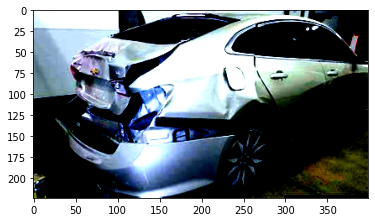

[('defect', 53.84815979003906)]

In [48]:
predict_img("./OIP.jpeg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


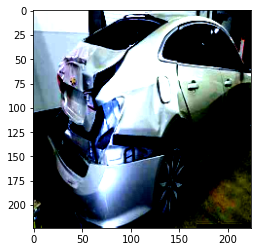

soft tensor([[0.5571, 0.4429]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5571]], grad_fn=<TopkBackward0>) tensor([[0]])


('Predicted :', 'defect')

In [50]:
predict_image_class_name('./OIP.jpeg',model) 